## 1. Preprocessing

All stock data and text data were placed into a single df, where each entry corresponds to a stock’s data on a given day together with the concatenated texts related to that stock for the same day.
At the same time, key classification labels were constructed: label_t+1 indicates whether the next day’s closing price is higher than the current day’s closing price; label_t+7 indicates whether the closing price seven days later is higher than the current day’s closing price.

Subsequently, key feature engineering was performed. We extracted the following structured features:<br>
   • return: defined as (closing_price – opening_price) / opening_price, measuring the magnitude of price movement during the trading day;<br>
   • volatility: defined as (highest_price – lowest_price) / opening_price, reflecting the instability of price fluctuations during the day;<br>
   • text_length: the total number of tokens after word segmentation of all concatenated texts for that day, serving as an indirect indicator of corpus density;<br>
   • engagement_score: a composite metric of like_num, retweet_num, and comment_num, measuring the dissemination and influence of the text. During construction, missing values were filled with 0 to prevent the model from being biased due to incomplete data.<br>

Finally, all key numerical features were standardized.


In [1]:
import pandas as pd
import os

# 股票 CSV 列表
stock_files = ["AAPL.csv", "AMZN.csv", "GOOG.csv", "GOOGL.csv", "MSFT.csv", "TSLA.csv"]

# 合并所有股票数据
stock_data = []
for file in stock_files:
    df = pd.read_csv(file)
    ticker = file.replace(".csv", "")
    df["ticker_symbol"] = ticker
    df["date"] = pd.to_datetime(df["date"]).dt.strftime("%Y-%m-%d")
    df["label_t+1"] = (df["close"].shift(-1) > df["close"]).astype(int)
    df["label_t+7"] = (df["close"].shift(-7) > df["close"]).astype(int)
    stock_data.append(df)

stock_df = pd.concat(stock_data, ignore_index=True)

In [2]:
stock_df

,date,open,high,low,close,adj close,volume,ticker_symbol,label_t+1,label_t+7
0,2023-12-28,194.139999,194.660004,193.169998,193.580002,193.580002,34014500,AAPL,0,1
1,2023-12-27,192.490005,193.500000,191.089996,193.149994,193.149994,48087700,AAPL,0,1
2,2023-12-26,193.610001,193.889999,192.830002,193.050003,193.050003,28919300,AAPL,1,1
3,2023-12-22,195.179993,195.410004,192.970001,193.600006,193.600006,37122800,AAPL,1,1
4,2023-12-21,196.100006,197.080002,193.500000,194.679993,194.679993,46482500,AAPL,1,1
...,...,...,...,...,...,...,...,...,...,...
39278,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900,TSLA,1,0
39279,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800,TSLA,1,0
39280,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800,TSLA,1,0
39281,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100,TSLA,1,0


In [3]:
# 读取推文数据
tweet_df = pd.read_csv("Tweet.csv")
company_tweet_df = pd.read_csv("Company_Tweet.csv")

# 合并推文和ticker
tweets_merged = pd.merge(company_tweet_df, tweet_df, on="tweet_id")
tweets_merged["post_date"] = pd.to_datetime(tweets_merged["post_date"], unit="s", errors="coerce")
tweets_merged["date"] = tweets_merged["post_date"].dt.strftime("%Y-%m-%d")

# 计算互动得分
tweets_merged["engagement_score"] = (
    tweets_merged["like_num"] + 2 * tweets_merged["retweet_num"] + 0.5 * tweets_merged["comment_num"]
)

# 聚合推文（每天每公司合并为一条）
agg_tweets = tweets_merged.groupby(["ticker_symbol", "date"]).agg({
    "body": lambda x: " ".join(str(i) for i in x),
    "engagement_score": "sum"
}).reset_index()

# 合并股票和推文数据
merged_df = pd.merge(stock_df, agg_tweets, on=["ticker_symbol", "date"], how="left")
merged_df.dropna(subset=["body"], inplace=True)

In [4]:
merged_df

,date,open,high,low,close,adj close,volume,ticker_symbol,label_t+1,label_t+7,body,engagement_score
1005,2019-12-31,289.929993,293.679993,289.519989,293.649994,292.954712,25201400,AAPL,0,0,Apple & Facebook Had Best Year Out of All FAAN...,2524.5
1006,2019-12-30,289.459991,292.690002,285.220001,291.519989,290.829773,36028600,AAPL,0,0,$AAPL 1H chart. Still inside the channel. Got ...,3862.0
1007,2019-12-27,291.119995,293.970001,288.119995,289.799988,289.113831,36566500,AAPL,1,0,More #TradeHacks in my #ebooks.Available on #i...,1268.0
1008,2019-12-26,284.820007,289.980011,284.700012,289.910004,289.223602,23280300,AAPL,0,0,$AAPL Apple’s iPhone XR outsold every other sm...,2894.0
1009,2019-12-24,284.690002,284.890015,282.920013,284.269989,283.596924,12119700,AAPL,0,0,$AAPL $AMD $AMZN - Tech Is Just Getting Starte...,1485.0
...,...,...,...,...,...,...,...,...,...,...,...,...
38142,2015-01-08,212.809998,213.800003,210.009995,210.619995,210.619995,3442500,TSLA,1,1,Correction: Photo via moi. ;) MT @CalvinKlesmi...,312.5
38143,2015-01-07,213.350006,214.779999,209.779999,210.949997,210.949997,2968400,TSLA,1,1,@JFinDallas @hmeisler That show about $TWTR $T...,339.0
38144,2015-01-06,210.059998,214.199997,204.210007,211.279999,211.279999,6261900,TSLA,0,1,Stock Market Analysis Jan 5th 2015 Big Down Da...,241.0
38145,2015-01-05,214.550003,216.500000,207.160004,210.089996,210.089996,5368500,TSLA,1,1,"$TSLA Monthly closed below 13ma, bearish down ...",377.0


In [5]:
from sklearn.preprocessing import StandardScaler

# 特征工程
merged_df["return"] = (merged_df["close"] - merged_df["open"]) / merged_df["open"]
merged_df["volatility"] = (merged_df["high"] - merged_df["low"]) / merged_df["open"]
merged_df["text_length"] = merged_df["body"].apply(lambda x: len(str(x).split()))
merged_df["engagement_score"] = merged_df["engagement_score"].fillna(0)
merged_df

,date,open,high,low,close,adj close,volume,ticker_symbol,label_t+1,label_t+7,body,engagement_score,return,volatility,text_length
1005,2019-12-31,289.929993,293.679993,289.519989,293.649994,292.954712,25201400,AAPL,0,0,Apple & Facebook Had Best Year Out of All FAAN...,2524.5,0.012831,0.014348,14814
1006,2019-12-30,289.459991,292.690002,285.220001,291.519989,290.829773,36028600,AAPL,0,0,$AAPL 1H chart. Still inside the channel. Got ...,3862.0,0.007117,0.025807,15847
1007,2019-12-27,291.119995,293.970001,288.119995,289.799988,289.113831,36566500,AAPL,1,0,More #TradeHacks in my #ebooks.Available on #i...,1268.0,-0.004534,0.020095,7972
1008,2019-12-26,284.820007,289.980011,284.700012,289.910004,289.223602,23280300,AAPL,0,0,$AAPL Apple’s iPhone XR outsold every other sm...,2894.0,0.017871,0.018538,14890
1009,2019-12-24,284.690002,284.890015,282.920013,284.269989,283.596924,12119700,AAPL,0,0,$AAPL $AMD $AMZN - Tech Is Just Getting Starte...,1485.0,-0.001475,0.006920,8151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38142,2015-01-08,212.809998,213.800003,210.009995,210.619995,210.619995,3442500,TSLA,1,1,Correction: Photo via moi. ;) MT @CalvinKlesmi...,312.5,-0.010291,0.017809,3763
38143,2015-01-07,213.350006,214.779999,209.779999,210.949997,210.949997,2968400,TSLA,1,1,@JFinDallas @hmeisler That show about $TWTR $T...,339.0,-0.011249,0.023436,3921
38144,2015-01-06,210.059998,214.199997,204.210007,211.279999,211.279999,6261900,TSLA,0,1,Stock Market Analysis Jan 5th 2015 Big Down Da...,241.0,0.005808,0.047558,3476
38145,2015-01-05,214.550003,216.500000,207.160004,210.089996,210.089996,5368500,TSLA,1,1,"$TSLA Monthly closed below 13ma, bearish down ...",377.0,-0.020788,0.043533,4495


In [6]:
# 数值特征缩放
merged_df["open_raw"] = merged_df["open"]
merged_df["close_raw"] = merged_df["close"]
numeric_features = ["open", "high", "low", "close", "volume", "engagement_score", "return", "volatility", "text_length"]
scaler = StandardScaler()
merged_df[numeric_features] = scaler.fit_transform(merged_df[numeric_features])

### The final result is the following dataframe after standardization of the key numerical variables:

In [7]:
merged_df

,date,open,high,low,close,adj close,volume,ticker_symbol,label_t+1,label_t+7,body,engagement_score,return,volatility,text_length,open_raw,close_raw
1005,2019-12-31,-0.585803,-0.584217,-0.580385,-0.578393,292.954712,0.714133,AAPL,0,0,Apple & Facebook Had Best Year Out of All FAAN...,0.232822,0.857086,-0.457025,0.644086,289.929993,293.649994
1006,2019-12-30,-0.586763,-0.586222,-0.589251,-0.582744,290.829773,1.359341,AAPL,0,0,$AAPL 1H chart. Still inside the channel. Got ...,0.600312,0.466198,0.411887,0.757110,289.459991,291.519989
1007,2019-12-27,-0.583373,-0.583629,-0.583272,-0.586258,289.113831,1.391395,AAPL,1,0,More #TradeHacks in my #ebooks.Available on #i...,-0.112412,-0.330830,-0.021255,-0.104516,291.119995,289.799988
1008,2019-12-26,-0.596239,-0.591711,-0.590324,-0.586033,289.223602,0.599652,AAPL,0,0,$AAPL Apple’s iPhone XR outsold every other sm...,0.334346,1.201883,-0.139311,0.652402,284.820007,289.910004
1009,2019-12-24,-0.596505,-0.602022,-0.593994,-0.597555,283.596924,-0.065423,AAPL,0,0,$AAPL $AMD $AMZN - Tech Is Just Getting Starte...,-0.052790,-0.121574,-1.020343,-0.084931,284.690002,284.269989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38142,2015-01-08,-0.743306,-0.746019,-0.744329,-0.748010,210.619995,-0.582509,TSLA,1,1,Correction: Photo via moi. ;) MT @CalvinKlesmi...,-0.374944,-0.724636,-0.194567,-0.565035,212.809998,210.619995
38143,2015-01-07,-0.742204,-0.744034,-0.744803,-0.747336,210.949997,-0.610762,TSLA,1,1,@JFinDallas @hmeisler That show about $TWTR $T...,-0.367663,-0.790191,0.232088,-0.547748,213.350006,210.949997
38144,2015-01-06,-0.748923,-0.745209,-0.756288,-0.746662,211.279999,-0.414498,TSLA,0,1,Stock Market Analysis Jan 5th 2015 Big Down Da...,-0.394590,0.376663,2.061319,-0.596436,210.059998,211.279999
38145,2015-01-05,-0.739753,-0.740550,-0.750206,-0.749093,210.089996,-0.467736,TSLA,1,1,"$TSLA Monthly closed below 13ma, bearish down ...",-0.357222,-1.442714,1.756107,-0.484945,214.550003,210.089996


## 2. Plot diagrams related to numerical variables

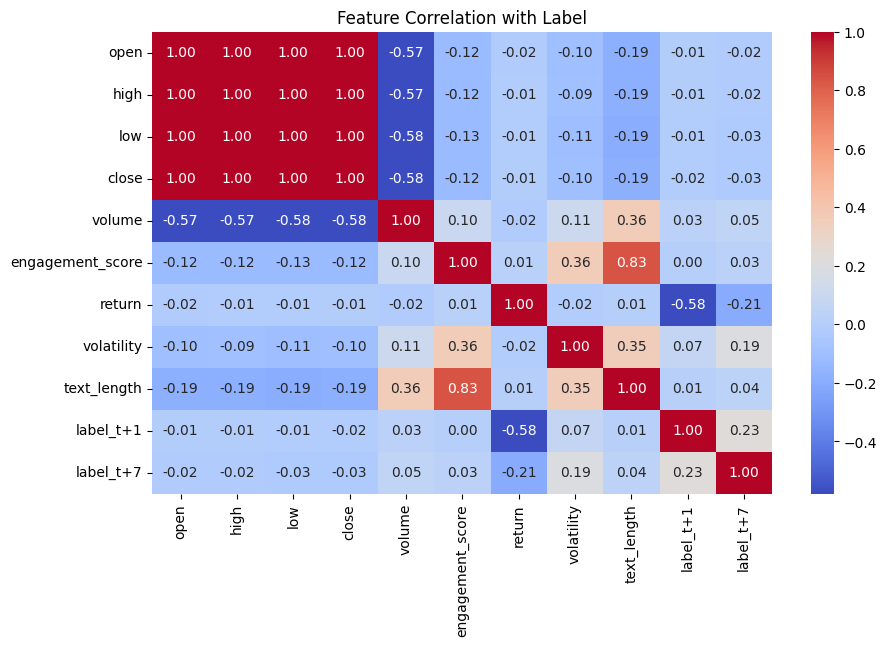

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


# 相关性热力图
plt.figure(figsize=(10, 6))
corr = merged_df[numeric_features + ["label_t+1"] + ["label_t+7"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation with Label")
plt.show()

Plot a heatmap to explore the relationships among variables. It was found that the daily return shows a strong correlation with both the next-day and the one-week-ahead price movements, and was therefore identified as a key variable.

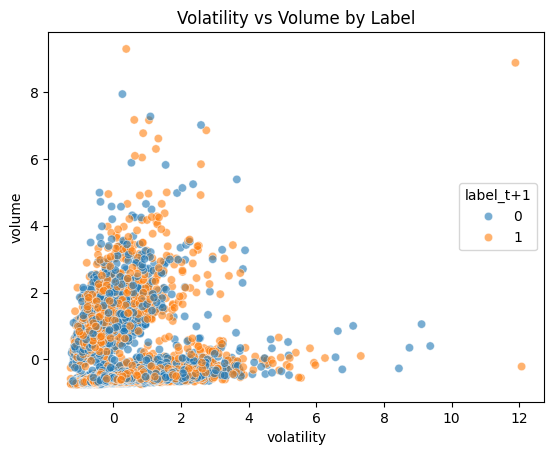

In [69]:
# 成交量与波动率的关系
sns.scatterplot(data=merged_df, x="volatility", y="volume", hue="label_t+1", alpha=0.6)
plt.title("Volatility vs Volume by Label")
plt.show()

探索成交量和波动率的关系

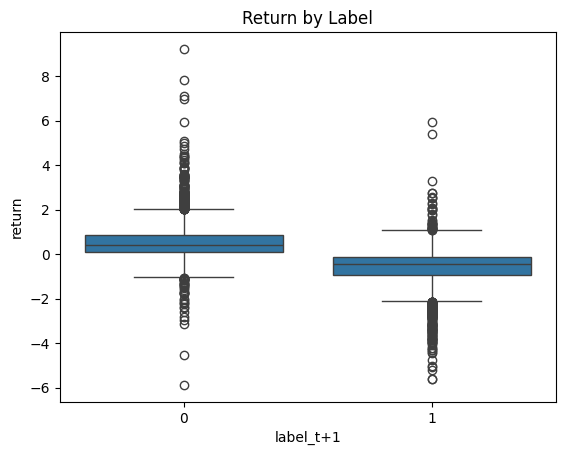

In [71]:
# 当日回报率按次日涨跌分布
sns.boxplot(data=merged_df, x="label_t+1", y="return")
plt.title("Return by Label")
plt.show()

A boxplot was subsequently generated to visualize the relationship between daily return and the subsequent day’s price movement.

t+1 涨跌比例：
label_t+1
0    53.18%
1    46.82%
Name: proportion, dtype: object

t+7 涨跌比例：
label_t+7
0    58.56%
1    41.44%
Name: proportion, dtype: object


/var/folders/pc/09w3lq795wq6183xnb732j300000gn/T/ipykernel_63056/156978900.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Down/Flat", "Up"])
/var/folders/pc/09w3lq795wq6183xnb732j300000gn/T/ipykernel_63056/156978900.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["Down/Flat", "Up"])


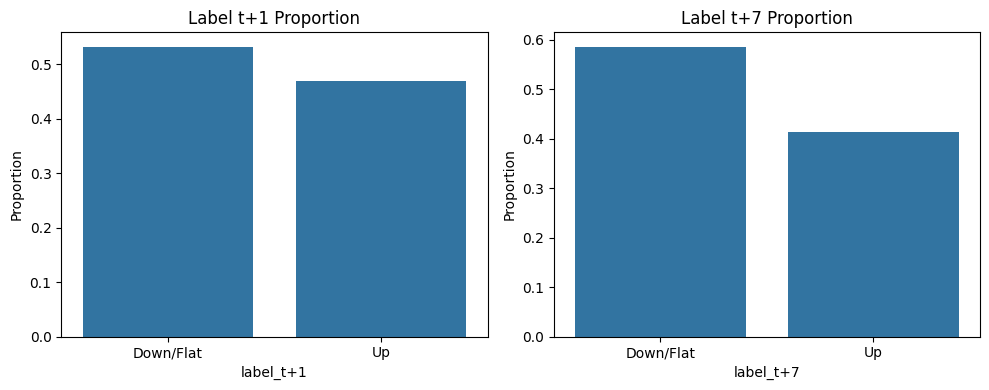

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# 统计数量
count_t1 = merged_df["label_t+1"].value_counts(normalize=True).sort_index()
count_t7 = merged_df["label_t+7"].value_counts(normalize=True).sort_index()

# 打印百分比
print("t+1 涨跌比例：")
print(count_t1.apply(lambda x: f"{x:.2%}"))

print("\nt+7 涨跌比例：")
print(count_t7.apply(lambda x: f"{x:.2%}"))

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(x=count_t1.index, y=count_t1.values, ax=axes[0])
axes[0].set_title("Label t+1 Proportion")
axes[0].set_xticklabels(["Down/Flat", "Up"])
axes[0].set_ylabel("Proportion")

sns.barplot(x=count_t7.index, y=count_t7.values, ax=axes[1])
axes[1].set_title("Label t+7 Proportion")
axes[1].set_xticklabels(["Down/Flat", "Up"])
axes[1].set_ylabel("Proportion")

plt.tight_layout()
plt.show()

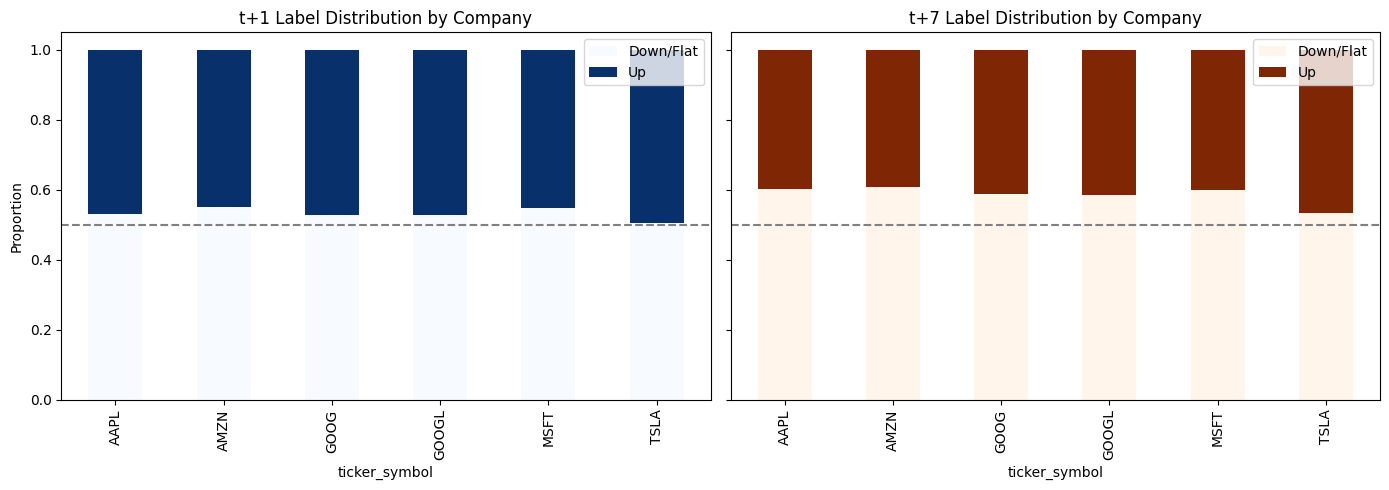

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算比例
grouped_t1 = merged_df.groupby("ticker_symbol")["label_t+1"].value_counts(normalize=True).unstack()
grouped_t7 = merged_df.groupby("ticker_symbol")["label_t+7"].value_counts(normalize=True).unstack()

# 重命名列
grouped_t1.columns = ["Down/Flat", "Up"]
grouped_t7.columns = ["Down/Flat", "Up"]

# 绘图
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

grouped_t1.plot(kind="bar", stacked=True, ax=axes[0], colormap="Blues")
axes[0].set_title("t+1 Label Distribution by Company")
axes[0].set_ylabel("Proportion")
axes[0].axhline(0.5, linestyle="--", color="gray")
axes[0].legend(loc="upper right")

grouped_t7.plot(kind="bar", stacked=True, ax=axes[1], colormap="Oranges")
axes[1].set_title("t+7 Label Distribution by Company")
axes[1].axhline(0.5, linestyle="--", color="gray")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

The analysis presents both the aggregate and firm-level proportions of upward and downward price movements over all observed trading days.

## 3. Construct the baseline model

This project designed and implemented four baseline models to investigate the impact of different feature combinations and model architectures on stock movement prediction. The first three models relied solely on the engineered numerical features—namely open, volume, engagement_score, return, volatility, and text_length—and were trained using Random Forest, XGBoost, and Multilayer Perceptron (MLP), respectively. All were run with default hyperparameters to serve as initial performance references. The fourth model incorporated natural language processing techniques by employing BERT to extract semantic embeddings from text, which were then fused with the aforementioned numerical features and fed into a deep neural network for classification. This model was designed to capture the influence of textual sentiment on short-term stock fluctuations, while structurally enabling the joint modeling of semantic information and quantitative indicators.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# 选择特征列表
selected_features = ["open", "volume", "engagement_score", "return", "volatility", "text_length"]

# 拆分数据
X = merged_df[selected_features]
y = merged_df["label_t+1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### With respect to the t+1 forecast 

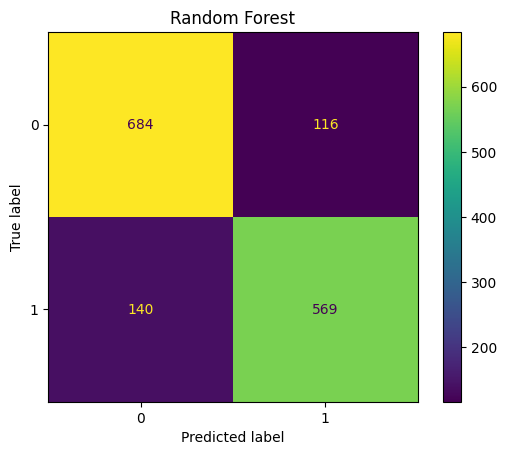

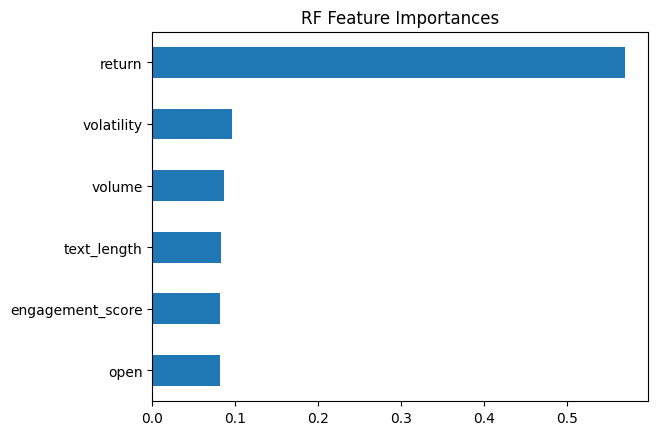

In [73]:
# 模型1：Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest(t+1)")
plt.show()

# 特征重要性图（RF）
pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind="barh", title="RF Feature Importances")
plt.show()

/opt/miniconda3/envs/work/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:09:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


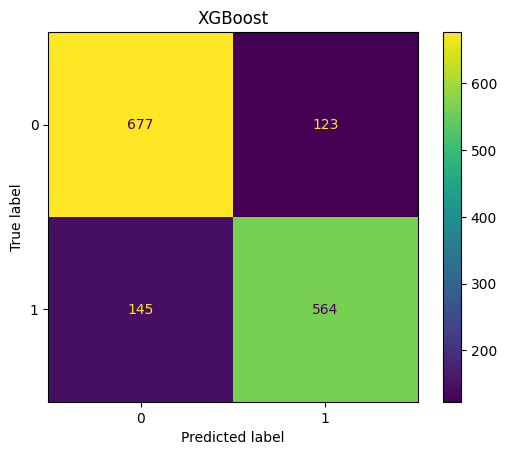

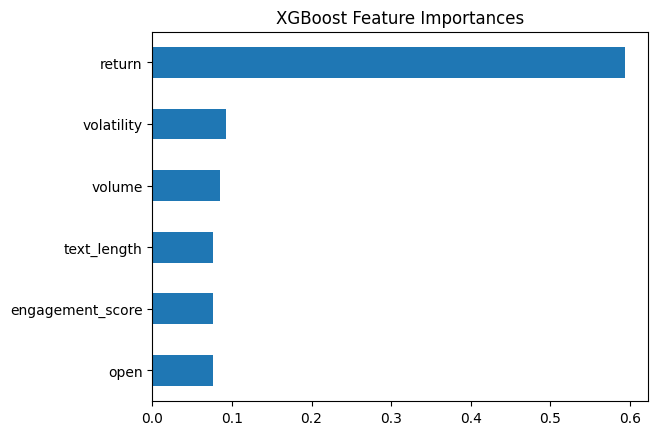

In [74]:
# 模型2：XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)
plt.title("XGBoost(t+1)")
plt.show()

# 特征重要性图（XGB）
pd.Series(xgb.feature_importances_, index=X.columns).sort_values().plot(kind="barh", title="XGBoost Feature Importances")
plt.show()

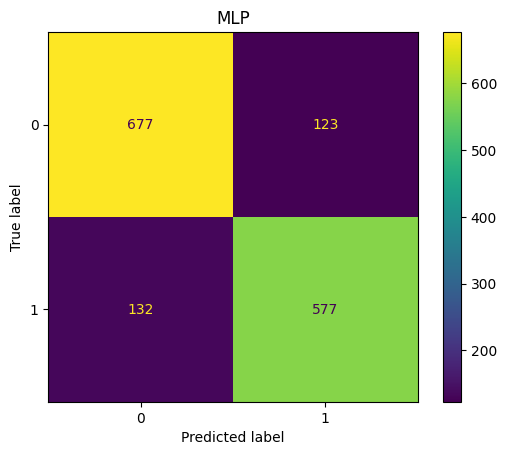

In [75]:
# 模型3：MLP
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test)
plt.title("MLP(t+1)")
plt.show()

In [76]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score
from scipy.stats import ks_2samp

def evaluate_metrics(model, X_test, y_test, model_name="Model"):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # KS Score：正样本与负样本的预测分数分布之间的最大差值
    ks = ks_2samp(y_prob[y_test == 1], y_prob[y_test == 0]).statistic

    print(f"=== {model_name} ===")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")
    print(f"KS Score : {ks:.4f}")
    print()

# 调用
evaluate_metrics(rf, X_test, y_test, model_name="Random Forest")
evaluate_metrics(xgb, X_test, y_test, model_name="XGBoost")
evaluate_metrics(mlp, X_test, y_test, model_name="MLP")

=== Random Forest ===
Accuracy : 0.8304
Precision: 0.8307
Recall   : 0.8025
F1 Score : 0.8164
AUC      : 0.9105
KS Score : 0.6720

=== XGBoost ===
Accuracy : 0.8224
Precision: 0.8210
Recall   : 0.7955
F1 Score : 0.8080
AUC      : 0.9073
KS Score : 0.6511

=== MLP ===
Accuracy : 0.8310
Precision: 0.8243
Recall   : 0.8138
F1 Score : 0.8190
AUC      : 0.9154
KS Score : 0.6662



In [48]:
# 模型4: 采用BERT构建文本向量，融合关键数值特征
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# 选择文本和数值特征
text_data = merged_df["body"].tolist()
numeric_data = merged_df[["return", "engagement_score", "volume"]].values
labels = merged_df["label_t+1"].values

# 分割数据
X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    text_data, numeric_data, labels, test_size=0.2, random_state=42
)

# 加载BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 自定义数据集
class BertFusionDataset(Dataset):
    def __init__(self, texts, nums, labels):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
        self.nums = torch.tensor(nums, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["num_feats"] = self.nums[idx]
        item["labels"] = self.labels[idx]
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = BertFusionDataset(X_text_train, X_num_train, y_train)
test_dataset = BertFusionDataset(X_text_test, X_num_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# 模型结构：BERT + 数值特征
class BertWithNumeric(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.2)
        self.num_dense = nn.Linear(3, 16)
        self.classifier = nn.Linear(768 + 16, 2)
    def forward(self, input_ids, attention_mask, num_feats):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = self.dropout(outputs.pooler_output)
        num_output = torch.relu(self.num_dense(num_feats))
        concat = torch.cat((cls_output, num_output), dim=1)
        logits = self.classifier(concat)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertWithNumeric().to(device)

# 优化器与损失
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# 简单训练循环
for epoch in range(2):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        num_feats = batch["num_feats"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, num_feats=num_feats)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# 推理
model.eval()
all_preds = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        num_feats = batch["num_feats"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, num_feats=num_feats)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(preds)

# 指标输出
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import ks_2samp

print(classification_report(y_test, all_preds, digits=4))
print(f"AUC Score: {roc_auc_score(y_test, all_probs):.4f}")
print(f"KS Score : {ks_2samp(np.array(all_probs)[np.array(y_test) == 1], 
                             np.array(all_probs)[np.array(y_test) == 0]).statistic:.4f}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1, Loss: 0.6920
Epoch 2, Loss: 0.6818
              precision    recall  f1-score   support

           0     0.7093    0.2013    0.3135       800
           1     0.5016    0.9069    0.6459       709

    accuracy                         0.5328      1509
   macro avg     0.6054    0.5541    0.4797      1509
weighted avg     0.6117    0.5328    0.4697      1509

AUC Score: 0.6624
KS Score : 0.2500


It can be observed that, for the t+1 prediction, the baseline models using only numerical features already achieved an accuracy exceeding 80%, largely due to the strong predictive power of the single-day return feature. In contrast, the integration of BERT embeddings—which inevitably encode substantial numerical information through text representation—diluted the explanatory strength of return, resulting in inferior performance.

### With respect to the t+7 forecast 

In [ ]:
y = merged_df["label_t+7"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

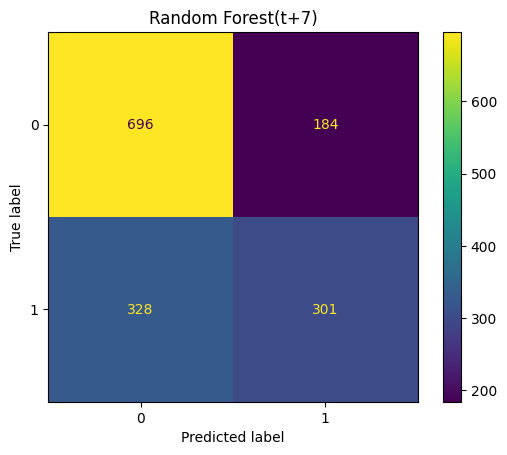

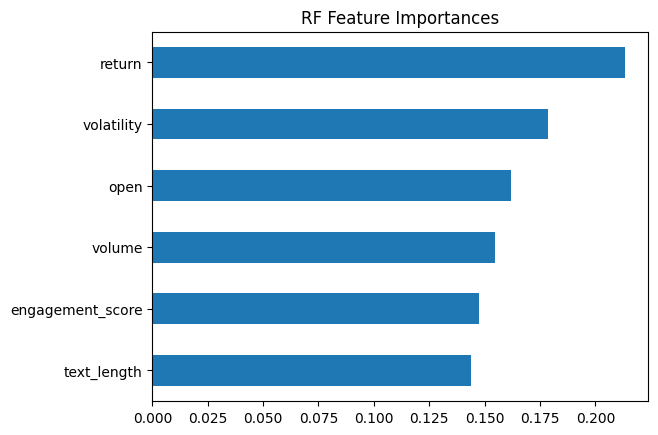

In [80]:
# 模型1：Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest(t+7)")
plt.show()

# 特征重要性图（RF）
pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind="barh", title="RF Feature Importances")
plt.show()

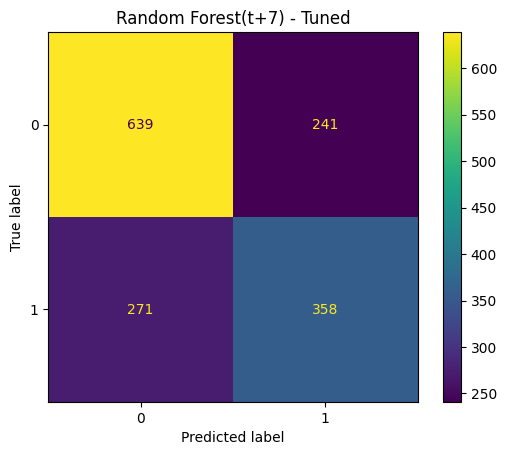

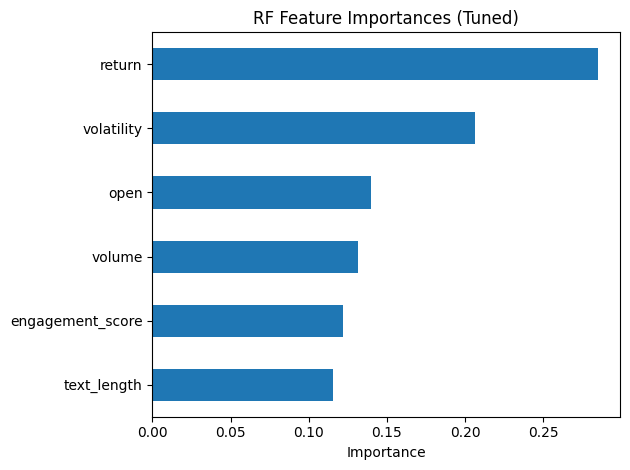

In [85]:
# 混淆矩阵
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Random Forest(t+7) - Tuned")
plt.show()

# 特征重要性图
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", title="RF Feature Importances (Tuned)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

/opt/miniconda3/envs/work/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


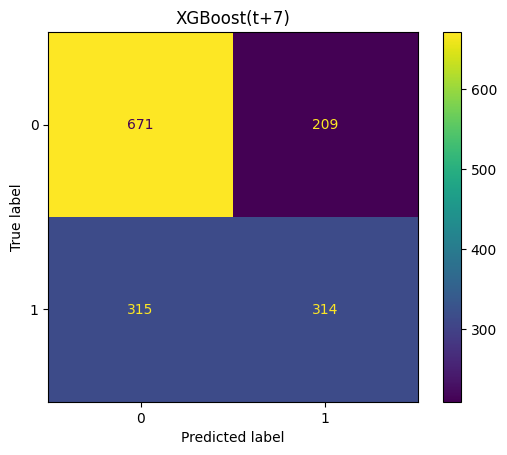

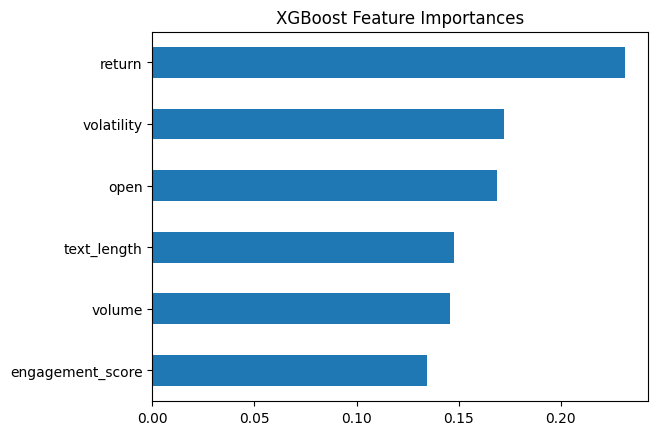

In [86]:
# 模型2：XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)
plt.title("XGBoost(t+7)")
plt.show()

# 特征重要性图（XGB）
pd.Series(xgb.feature_importances_, index=X.columns).sort_values().plot(kind="barh", title="XGBoost Feature Importances")
plt.show()

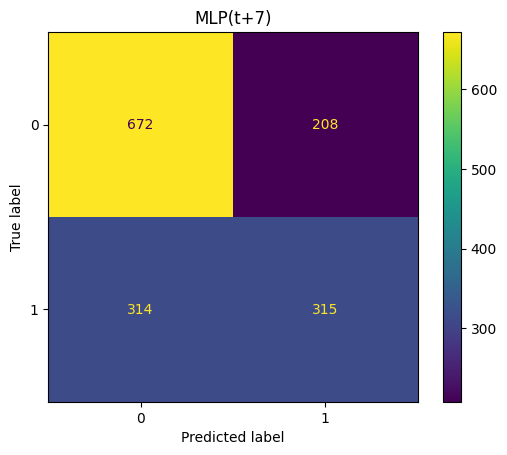

In [82]:
# 模型3：MLP
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test)
plt.title("MLP(t+7)")
plt.show()

In [88]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score
from scipy.stats import ks_2samp

def evaluate_metrics(model, X_test, y_test, model_name="Model"):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # KS Score：正样本与负样本的预测分数分布之间的最大差值
    ks = ks_2samp(y_prob[y_test == 1], y_prob[y_test == 0]).statistic

    print(f"=== {model_name} ===")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")
    print(f"KS Score : {ks:.4f}")
    print()

# 调用
evaluate_metrics(rf, X_test, y_test, model_name="Random Forest")
evaluate_metrics(xgb, X_test, y_test, model_name="XGBoost")
evaluate_metrics(mlp, X_test, y_test, model_name="MLP")

=== Random Forest ===
Accuracy : 0.6607
Precision: 0.6206
Recall   : 0.4785
F1 Score : 0.5404
AUC      : 0.6897
KS Score : 0.2824

=== XGBoost ===
Accuracy : 0.6528
Precision: 0.6004
Recall   : 0.4992
F1 Score : 0.5451
AUC      : 0.6942
KS Score : 0.3025

=== MLP ===
Accuracy : 0.6541
Precision: 0.6023
Recall   : 0.5008
F1 Score : 0.5469
AUC      : 0.6869
KS Score : 0.2794



In [9]:
# 模型4: 采用BERT构建文本向量，融合关键数值特征
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# 选择文本和数值特征
text_data = merged_df["body"].tolist()
numeric_data = merged_df[["return", "engagement_score", "volume"]].values
labels = merged_df["label_t+7"].values

# 分割数据
X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    text_data, numeric_data, labels, test_size=0.2, random_state=42
)

# 加载BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 自定义数据集
class BertFusionDataset(Dataset):
    def __init__(self, texts, nums, labels):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
        self.nums = torch.tensor(nums, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["num_feats"] = self.nums[idx]
        item["labels"] = self.labels[idx]
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = BertFusionDataset(X_text_train, X_num_train, y_train)
test_dataset = BertFusionDataset(X_text_test, X_num_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# 模型结构：BERT + 数值特征
class BertWithNumeric(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.2)
        self.num_dense = nn.Linear(3, 16)
        self.classifier = nn.Linear(768 + 16, 2)
    def forward(self, input_ids, attention_mask, num_feats):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = self.dropout(outputs.pooler_output)
        num_output = torch.relu(self.num_dense(num_feats))
        concat = torch.cat((cls_output, num_output), dim=1)
        logits = self.classifier(concat)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertWithNumeric().to(device)

# 优化器与损失
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# 简单训练循环
for epoch in range(2):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        num_feats = batch["num_feats"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, num_feats=num_feats)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# 推理
model.eval()
all_preds = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        num_feats = batch["num_feats"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, num_feats=num_feats)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(preds)

# 指标输出
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import ks_2samp

print(classification_report(y_test, all_preds, digits=4))
print(f"AUC Score: {roc_auc_score(y_test, all_probs):.4f}")
print(f"KS Score : {ks_2samp(np.array(all_probs)[np.array(y_test) == 1], 
                             np.array(all_probs)[np.array(y_test) == 0]).statistic:.4f}")

Epoch 1, Loss: 0.6879
Epoch 2, Loss: 0.6820
Epoch 3, Loss: 0.6799
Epoch 4, Loss: 0.6580
Epoch 5, Loss: 0.5670
Epoch 6, Loss: 0.3847
Epoch 7, Loss: 0.2231
Epoch 8, Loss: 0.1236
Epoch 9, Loss: 0.0980
Epoch 10, Loss: 0.0705
              precision    recall  f1-score   support

           0     0.6387    0.5364    0.5831       880
           1     0.4701    0.5755    0.5175       629

    accuracy                         0.5527      1509
   macro avg     0.5544    0.5559    0.5503      1509
weighted avg     0.5684    0.5527    0.5557      1509

AUC Score: 0.5884


NameError: name 'np' is not defined

In the t+7 task, daily return was less correlated with one-week-ahead movements compared to next-day changes, but it remained the top contributing numerical feature. Using only numerical variables, the three baseline models still reached stable accuracies above 65%.

## 4.Main Model: BERT-based Sentiment Classification

From the baseline experiments, return proved to be the most important numerical feature. To avoid text embeddings diluting its effect, we cleaned the text data and used a pre-trained BERT sentiment model to generate a sentiment score, which was added to the numerical feature set. Using this new set, Random Forest, XGBoost, and MLP were tuned with grid search and 3-fold CV, and their optimized versions were ensembled into the final best model.

In [162]:
import re
import pandas as pd
import numpy as np
from transformers import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from scipy.stats import ks_2samp

# ========= Step 1: 文本清洗函数 ========= #
import string

def clean_financial_text(text: str) -> str:
    """
    清洗金融文本以用于BERT情感识别模型输入。
    步骤包括：去除股票代码、链接、标点、过度空格，统一小写等。
    """
    if not isinstance(text, str):
        return ""

    # 1. 去除股票代码，如 $AAPL、$TSLA
    text = re.sub(r'\$\w+', '', text)

    # 2. 去除 URL（http, https 开头）
    text = re.sub(r'http\S+|www\S+', '', text)

    # 3. 去除 HTML 标签（如 <br>）
    text = re.sub(r'<.*?>', '', text)

    # 4. 替换 &amp; 等HTML转义字符（可扩展）
    text = text.replace("&amp;", "and")

    # 5. 转小写
    text = text.lower()

    # 6. 去除标点符号（可以保留“.”和“?”用于某些模型，如需）
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 7. 去除多余空格
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# ========= Step 2: 清洗文本 ========= #
merged_df["body_clean"] = merged_df["body"].apply(clean_tweet)

# ========= Step 3: 使用 BERT 做情感分析 ========= #
classifier = pipeline("sentiment-analysis")

def get_bert_sentiment_score(text):
    result = classifier(text[:512])[0]
    score = result["score"]
    return score if result["label"] == "POSITIVE" else -score

merged_df["bert_sentiment"] = merged_df["body_clean"].apply(get_bert_sentiment_score)

# ========= Step 4: 构建训练集（结构特征 + 情感特征） ========= #
selected_features = ["return", "engagement_score", "volume", "bert_sentiment"]
scaler = StandardScaler()
merged_df[selected_features] = scaler.fit_transform(merged_df[selected_features])

X = merged_df[selected_features]
y = merged_df["label_t+1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


### With respect to the t+1 forecast

Fitting 3 folds for each of 30 candidates, totalling 90 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

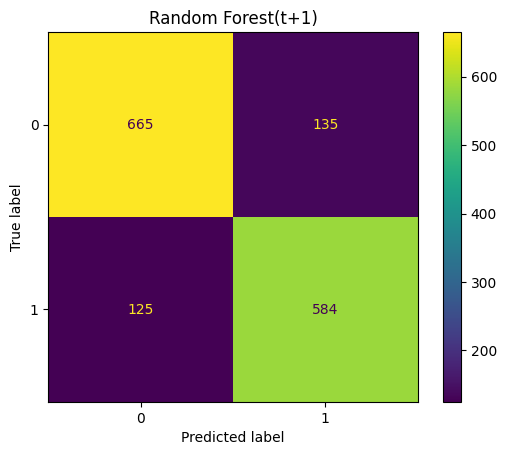

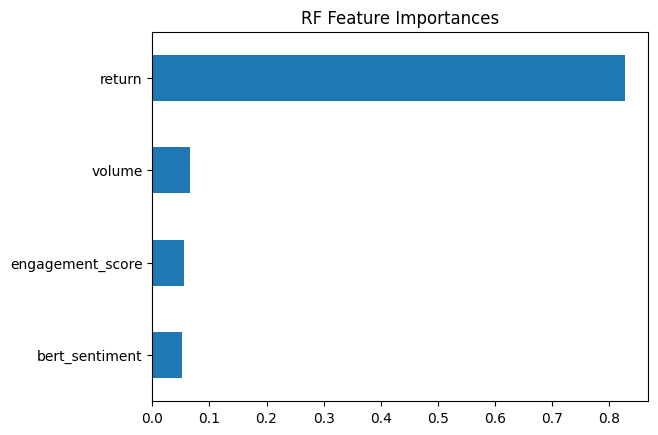

In [133]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

rf_param_grid = {
    "n_estimators": randint(100, 600),
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5),
    "max_features": ['sqrt', 'log2'],
    "class_weight": ['balanced', None]
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=30,  # 可调
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

ConfusionMatrixDisplay.from_estimator(rf_best, X_test, y_test)
plt.title("Random Forest(t+1)")
plt.show()

# 特征重要性图（RF）
pd.Series(rf_best.feature_importances_, index=X.columns).sort_values().plot(kind="barh", title="RF Feature Importances")
plt.show()

Fitting 3 folds for each of 30 candidates, totalling 90 fits


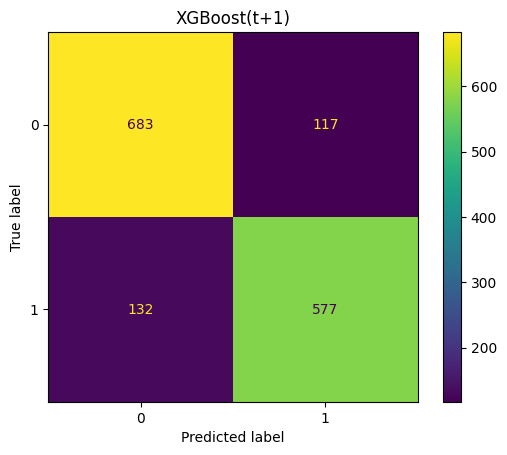

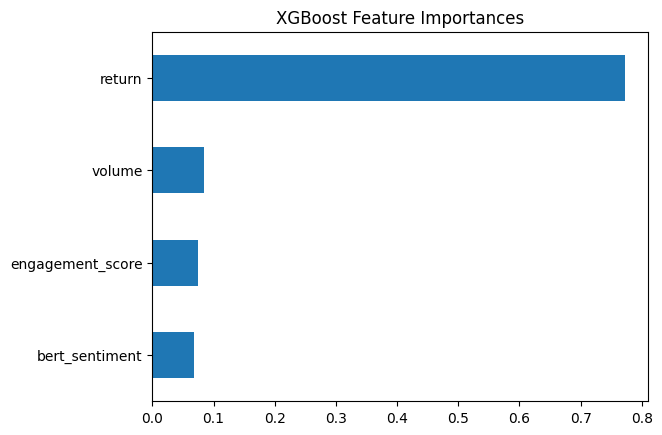

In [134]:
xgb_param_grid = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.2),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
    "gamma": uniform(0, 5),
}

xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric="logloss", random_state=42),
    param_distributions=xgb_param_grid,
    n_iter=30,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
xgb_search.fit(X_train, y_train)
xgb_best = xgb_search.best_estimator_

ConfusionMatrixDisplay.from_estimator(xgb_best, X_test, y_test)
plt.title("XGBoost(t+1)")
plt.show()

# 特征重要性图（XGB）
pd.Series(xgb_best.feature_importances_, index=X.columns).sort_values().plot(kind="barh", title="XGBoost Feature Importances")
plt.show()

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/miniconda3/envs/work/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/work/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/work/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


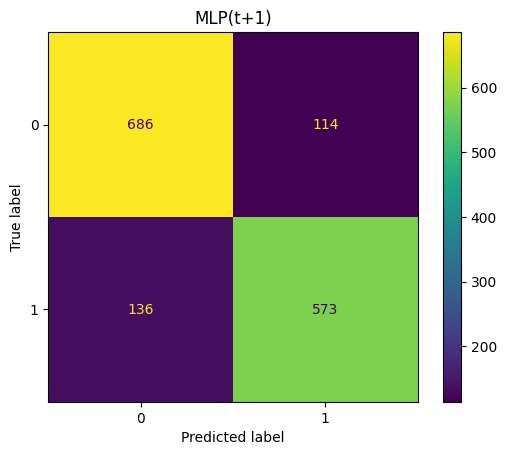

In [135]:
mlp_param_grid = {
    "hidden_layer_sizes": [(128, 64), (64, 32), (100,), (50, 25)],
    "activation": ['relu', 'tanh'],
    "solver": ['adam', 'sgd'],
    "alpha": uniform(0.0001, 0.01),
    "learning_rate": ['constant', 'adaptive'],
    "max_iter": [300]
}

mlp_search = RandomizedSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_distributions=mlp_param_grid,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
mlp_search.fit(X_train, y_train)
mlp_best = mlp_search.best_estimator_

ConfusionMatrixDisplay.from_estimator(mlp_best, X_test, y_test)
plt.title("MLP(t+1)")
plt.show()

In [136]:
evaluate_metrics(rf_best, X_test, y_test, model_name="Random Forest (Tuned)")
evaluate_metrics(xgb_best, X_test, y_test, model_name="XGBoost (Tuned)")
evaluate_metrics(mlp_best, X_test, y_test, model_name="MLP (Tuned)")

=== Random Forest (Tuned) ===
Accuracy : 0.8277
Precision: 0.8122
Recall   : 0.8237
F1 Score : 0.8179
AUC      : 0.9083
KS Score : 0.6677

=== XGBoost (Tuned) ===
Accuracy : 0.8350
Precision: 0.8314
Recall   : 0.8138
F1 Score : 0.8225
AUC      : 0.9157
KS Score : 0.6810

=== MLP (Tuned) ===
Accuracy : 0.8343
Precision: 0.8341
Recall   : 0.8082
F1 Score : 0.8209
AUC      : 0.9132
KS Score : 0.6813



=== Ensemble for t+1 (Stacking) ===
Accuracy : 0.8363
Precision: 0.8338
Recall   : 0.8138
F1 Score : 0.8237
AUC      : 0.9136
KS Score : 0.6779



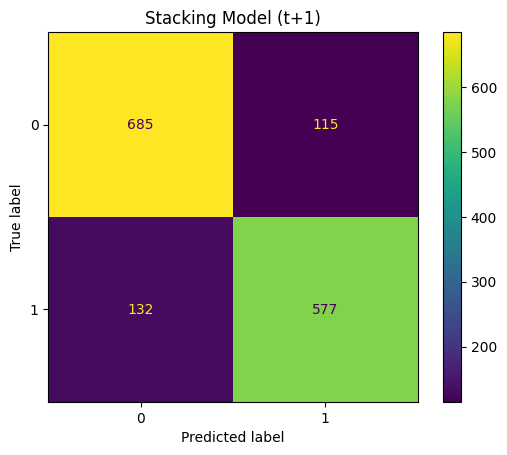

In [137]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression  # Meta-learner

stacking_model_t1 = StackingClassifier(
    estimators=[
        ('rf', rf_best),
        ('xgb', xgb_best),
        ('mlp', mlp_best)
    ],
    final_estimator=LogisticRegression(),
    cv=3,
    n_jobs=-1,
    passthrough=False  # True 会把原始特征也一起送入 meta-model
)

stacking_model_t1.fit(X_train, y_train)
evaluate_metrics(stacking_model_t1, X_test, y_test, model_name="Ensemble for t+1 (Stacking)")

ConfusionMatrixDisplay.from_estimator(stacking_model_t1, X_test, y_test)
plt.title("Stacking Model (t+1)")
plt.show()

The final model achieved an accuracy of 83.6%, which is slightly higher than that of the baseline models.

### With respect to the t+7 forecast

In [104]:
y = merged_df["label_t+7"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


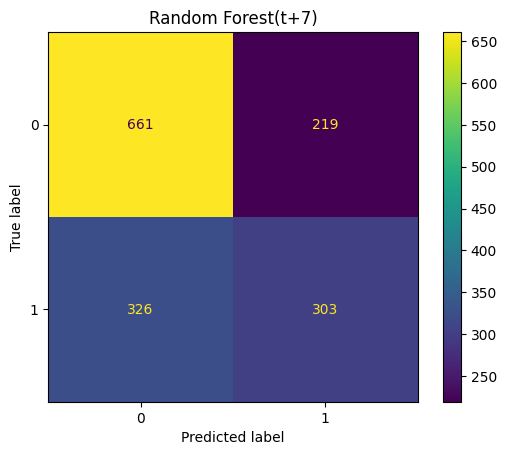

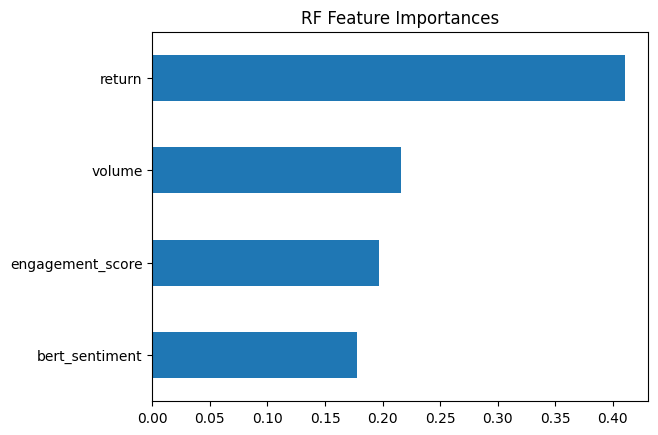

In [105]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

rf_param_grid = {
    "n_estimators": randint(100, 600),
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5),
    "max_features": ['sqrt', 'log2'],
    "class_weight": ['balanced', None]
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=30,  # 可调
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

ConfusionMatrixDisplay.from_estimator(rf_best, X_test, y_test)
plt.title("Random Forest(t+7)")
plt.show()

# 特征重要性图（RF）
pd.Series(rf_best.feature_importances_, index=X.columns).sort_values().plot(kind="barh", title="RF Feature Importances")
plt.show()

Fitting 3 folds for each of 30 candidates, totalling 90 fits


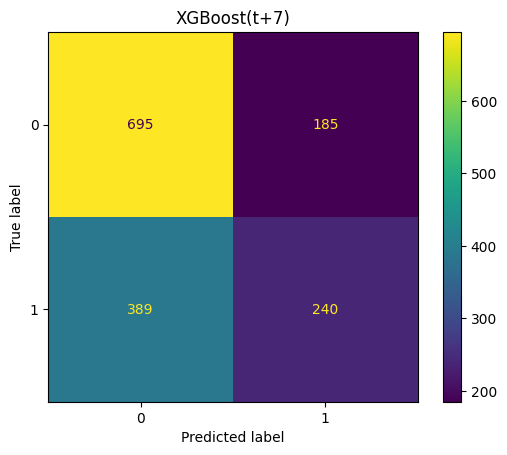

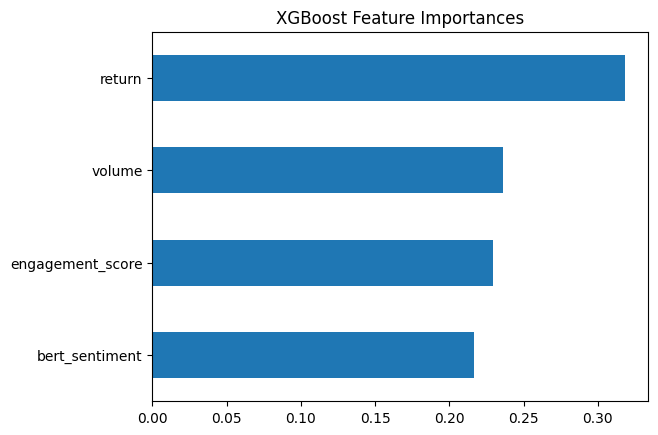

In [106]:
xgb_param_grid = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.2),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
    "gamma": uniform(0, 5),
}

xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric="logloss", random_state=42),
    param_distributions=xgb_param_grid,
    n_iter=30,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
xgb_search.fit(X_train, y_train)
xgb_best = xgb_search.best_estimator_

ConfusionMatrixDisplay.from_estimator(xgb_best, X_test, y_test)
plt.title("XGBoost(t+7)")
plt.show()

# 特征重要性图（XGB）
pd.Series(xgb_best.feature_importances_, index=X.columns).sort_values().plot(kind="barh", title="XGBoost Feature Importances")
plt.show()

Fitting 3 folds for each of 20 candidates, totalling 60 fits


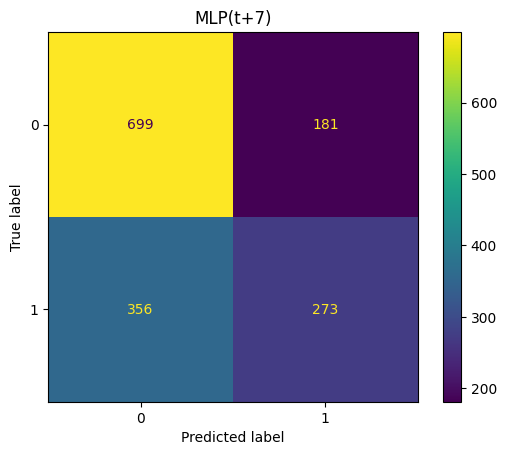

In [107]:
mlp_param_grid = {
    "hidden_layer_sizes": [(128, 64), (64, 32), (100,), (50, 25)],
    "activation": ['relu', 'tanh'],
    "solver": ['adam', 'sgd'],
    "alpha": uniform(0.0001, 0.01),
    "learning_rate": ['constant', 'adaptive'],
    "max_iter": [300]
}

mlp_search = RandomizedSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_distributions=mlp_param_grid,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
mlp_search.fit(X_train, y_train)
mlp_best = mlp_search.best_estimator_

ConfusionMatrixDisplay.from_estimator(mlp_best, X_test, y_test)
plt.title("MLP(t+7)")
plt.show()

In [108]:
evaluate_metrics(rf_best, X_test, y_test, model_name="Random Forest (Tuned)")
evaluate_metrics(xgb_best, X_test, y_test, model_name="XGBoost (Tuned)")
evaluate_metrics(mlp_best, X_test, y_test, model_name="MLP (Tuned)")

=== Random Forest (Tuned) ===
Accuracy : 0.6388
Precision: 0.5805
Recall   : 0.4817
F1 Score : 0.5265
AUC      : 0.6469
KS Score : 0.2458

=== XGBoost (Tuned) ===
Accuracy : 0.6196
Precision: 0.5647
Recall   : 0.3816
F1 Score : 0.4554
AUC      : 0.6046
KS Score : 0.1870

=== MLP (Tuned) ===
Accuracy : 0.6441
Precision: 0.6013
Recall   : 0.4340
F1 Score : 0.5042
AUC      : 0.6535
KS Score : 0.2397



=== Ensemble t+7 (Stacking) ===
Accuracy : 0.6494
Precision: 0.6302
Recall   : 0.3847
F1 Score : 0.4778
AUC      : 0.6499
KS Score : 0.2447



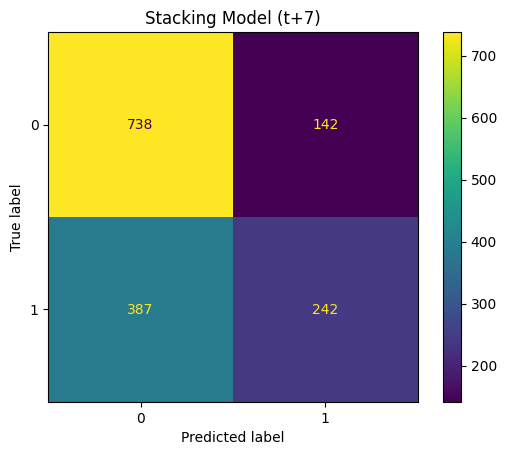

In [109]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression  # Meta-learner

stacking_model_t7 = StackingClassifier(
    estimators=[
        ('rf', rf_best),
        ('xgb', xgb_best),
        ('mlp', mlp_best)
    ],
    final_estimator=LogisticRegression(),
    cv=3,
    n_jobs=-1,
    passthrough=False  # True 会把原始特征也一起送入 meta-model
)

stacking_model_t7.fit(X_train, y_train)
evaluate_metrics(stacking_model_t7, X_test, y_test, model_name="Ensemble t+7 (Stacking)")

ConfusionMatrixDisplay.from_estimator(stacking_model_t7, X_test, y_test)
plt.title("Stacking Model (t+7)")
plt.show()

Ensemble learning achieved about 65% accuracy, which was not significantly different from the baselines.

In [159]:

def simulate_trading(y_pred, y_true, opens, closes, seed_money=10000):
    trades = []
    profits = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1:  # 预测涨
            open_price = opens[i]
            close_price = closes[i]
            shares = seed_money / open_price
            profit = (close_price - open_price) * shares
            trades.append(profit)
            profits.append(profit)
        else:
            trades.append(0.0)

    trades = np.array(trades)
    
    profits = np.array(profits)
    profits = profits[~np.isnan(profits)]
    avg_profit = np.mean(profits)
    win_rate = np.mean(profits > 0) if len(profits) > 0 else 0.0
    trade_count = len(profits)

    print(f"模拟交易完成：共进行了 {trade_count} 次交易")
    print(f"平均每笔交易利润: ${avg_profit:.2f}")
    print(f"胜率: {win_rate:.2%}")

    return trades

### t+1 Trading Simulation

In [160]:
merged_df["open_t+1"] = merged_df.groupby("ticker_symbol")["open_raw"].shift(-1)
merged_df["close_t+1"] = merged_df.groupby("ticker_symbol")["close_raw"].shift(-1)
# 1. 获取测试集预测结果
y_pred = stacking_model_t1.predict(X_test)

# 2. 同步价格信息
opens = merged_df.loc[X_test.index, "open_t+1"].values
closes = merged_df.loc[X_test.index, "close_t+1"].values

# 3. 执行模拟交易
simulate_trading(y_pred, y_test.values, opens, closes, seed_money=10000)

模拟交易完成：共进行了 692 次交易
平均每笔交易利润: $11.00
胜率: 54.62%


array([ 61.96722594,   0.        ,   0.        , ...,   0.        ,
        66.66477898, 300.1866669 ], shape=(1509,))

### t+7 Trading Simulation

In [161]:
merged_df["open_t+7"] = merged_df.groupby("ticker_symbol")["open_raw"].shift(-7)
merged_df["close_t+7"] = merged_df.groupby("ticker_symbol")["close_raw"].shift(-7)
# 1. 获取测试集预测结果
y_pred = stacking_model_t7.predict(X_test)

# 2. 同步价格信息
opens = merged_df.loc[X_test.index, "open_t+7"].values
closes = merged_df.loc[X_test.index, "close_t+7"].values

# 3. 执行模拟交易
simulate_trading(y_pred, y_test.values, opens, closes, seed_money=10000)

模拟交易完成：共进行了 380 次交易
平均每笔交易利润: $6.89
胜率: 53.42%


array([-77.00346479,   0.        ,   0.        , ...,   0.        ,
        35.99008278,   0.        ], shape=(1509,))

Simulation results show that our model enables traders to gain profits in both the short and long term.